<a href="https://colab.research.google.com/github/ChoiInYeol/Matrix-Factorization-Portfolio-Optimization-/blob/master/10_DL_49industy_Experience_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.getcwd()
os.chdir("/content/drive/MyDrive/Colab Notebooks/")

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding
from tensorflow.keras.layers import Flatten, Dot, Add
from keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.utils
from sklearn.model_selection import train_test_split
import pickle

from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint

# 주간 수익률 데이터를 읽어온다.
rtn_df = pd.read_csv('49_Industry_Portfolios_Daily_Value_logreturn.csv', index_col=0)
rtn_R = np.array(rtn_df)

N_FACTORS = 10    # number of factors
N_ROW = rtn_R.shape[0]    # time 개수
N_COL = rtn_R.shape[1]    # item (종목) 개수
print("Factor : ", N_FACTORS)
print("N_ROW : ", N_ROW)
print("N_COL : ", N_COL)

Factor :  10
N_ROW :  1727
N_COL :  49


In [48]:
# x_row_emb = Embedding(N_ROW, N_FACTORS, name='F')(x_input_row) #1727 * 10
# x_row_emb = Dropout(0.2)(x_row_emb)
# x_row_emb = Flatten()(x_row_emb)

# x_col_emb = Embedding(N_COL, N_FACTORS, name='B')(x_input_col) #49 * 10
# x_col_emb = Dropout(0.2)(x_col_emb)
# x_col_emb = Flatten()(x_col_emb)

# # Calculate the expected return
# y_output = Dot(axes=1)([x_row_emb, x_col_emb])
# model = Model([x_input_row, x_input_col], y_output)
# model.compile(loss='mean_squared_error', optimizer = Adam())

In [73]:
# mean centering
E = rtn_R.mean(axis=0).reshape(1, N_COL)
cent_R = rtn_R - E

# unpivoting
R = pd.DataFrame(cent_R).stack().reset_index()
R.columns = ['row', 'col', 'rtn']

# 데이터 세트를 생성한다.
x_row = np.array(R['row']).astype('int').reshape(-1, 1)
x_col = np.array(R['col']).astype('int').reshape(-1, 1)
y_rtn = np.array(R['rtn']).reshape(-1, 1)

# Create training and test data.
x_train_row, x_test_row, x_train_col, x_test_col, y_train, y_test = \
                    train_test_split(x_row, x_col, y_rtn, test_size = 0.1)

# Matrix factorization network
x_input_row = Input(batch_shape = (None, x_row.shape[1]))
x_input_col = Input(batch_shape = (None, x_col.shape[1]))

# f-network
x_row_emb = Embedding(N_ROW, N_FACTORS, name='F')(x_input_row) # 1727 -> 10
x_row_emb = Flatten()(x_row_emb)

# B-network
x_col_emb = Embedding(N_COL, N_FACTORS, name='B')(x_input_col) # 49 -> 10
x_col_emb = Flatten()(x_col_emb)

# Calculate the expected return
y_output = Concatenate()([x_row_emb, x_col_emb]) # 1727 * 20
y_output = Dense(1024, activation='relu')(y_output)
y_output = Dropout(0.2)(y_output)
y_output = Dense(1)(y_output)

model = Model([x_input_row, x_input_col], y_output)
model.compile(loss='mean_squared_error', optimizer = Adam(learning_rate=0.0005))

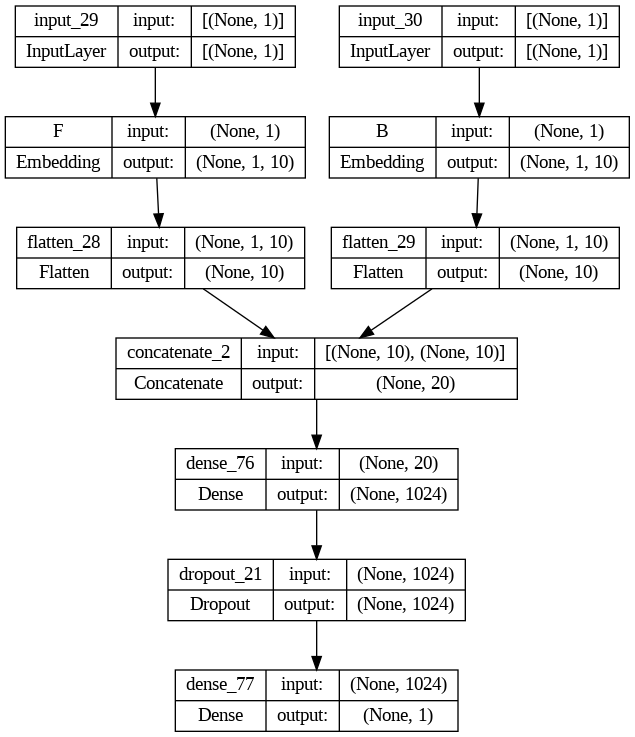

In [71]:
tensorflow.keras.utils.plot_model(model, show_shapes=True)

In [74]:
# Define learning rate schedule
def lr_schedule(epoch):
    lr = 0.0001
    if epoch > 60:
        lr *= 0.5
    elif epoch > 200:
        lr *= 0.1
    return lr

# Set up the learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=8)

filepath = 'best_model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='min', save_freq=5000)

In [75]:
# 학습
hist = model.fit([x_train_row, x_train_col], y_train, 
                  validation_data = ([x_test_row, x_test_col], y_test),
                  batch_size = 256, epochs = 500, callbacks=[early_stopping, lr_scheduler, checkpoint])

# loss history
plt.figure(figsize=(4,3))
plt.plot(hist.history['test_accuracy'], label='train loss')
plt.plot(hist.history['val_accuracy'], label='test loss')
plt.legend()
plt.show()

Epoch 1/500
298/298 [==============================] - ETA: 0s - loss: 0.0011

298/298 [==============================] - 6s 16ms/step - loss: 0.0011 - val_loss: 0.0011 - lr: 1.0000e-04
Epoch 2/500
298/298 [==============================] - ETA: 0s - loss: 8.5809e-04

298/298 [==============================] - 2s 5ms/step - loss: 8.5809e-04 - val_loss: 7.4222e-04 - lr: 1.0000e-04
Epoch 3/500
298/298 [==============================] - ETA: 0s - loss: 6.5211e-04

298/298 [==============================] - 1s 5ms/step - loss: 6.5211e-04 - val_loss: 6.3901e-04 - lr: 1.0000e-04
Epoch 4/500
289/298 [============================>.] - ETA: 0s - loss: 5.9691e-04

298/298 [==============================] - 1s 4ms/step - loss: 5.9528e-04 - val_loss: 6.0544e-04 - lr: 1.0000e-04
Epoch 5/500
298/298 [==============================] - ETA: 0s - loss: 5.7247e-04

298/298 [==============================] - 1s 5ms/step - loss: 5.7247e-04 - val_loss: 5.8950e-04 - lr: 1.0000e-04
Epoch 6/500
298/298 [==============================] - ETA: 0s - loss: 5.6139e-04

298/298 [==============================] - 1s 4ms/step - loss: 5.6139e-04 - val_loss: 5.8404e-04 - lr: 1.0000e-04
Epoch 7/500
284/298 [===========================>..] - ETA: 0s - loss: 5.5545e-04

298/298 [==============================] - 1s 4ms/step - loss: 5.5454e-04 - val_loss: 5.8019e-04 - lr: 1.0000e-04
Epoch 8/500
291/298 [============================>.] - ETA: 0s - loss: 5.4980e-04

298/298 [==============================] - 1s 4ms/step - loss: 5.5144e-04 - val_loss: 5.8018e-04 - lr: 1.0000e-04
Epoch 9/500
284/298 [===========================>..] - ETA: 0s - loss: 5.4615e-04

298/298 [==============================] - 1s 4ms/step - loss: 5.4846e-04 - val_loss: 5.7745e-04 - lr: 1.0000e-04
Epoch 10/500
297/298 [============================>.] - ETA: 0s - loss: 5.4753e-04

298/298 [==============================] - 2s 6ms/step - loss: 5.4715e-04 - val_loss: 5.7662e-04 - lr: 1.0000e-04
Epoch 11/500
298/298 [==============================] - ETA: 0s - loss: 5.4405e-04

298/298 [==============================] - 2s 6ms/step - loss: 5.4405e-04 - val_loss: 5.7562e-04 - lr: 1.0000e-04
Epoch 12/500
285/298 [===========================>..] - ETA: 0s - loss: 5.4447e-04

298/298 [==============================] - 1s 4ms/step - loss: 5.4257e-04 - val_loss: 5.7635e-04 - lr: 1.0000e-04
Epoch 13/500
298/298 [==============================] - ETA: 0s - loss: 5.4124e-04

298/298 [==============================] - 1s 4ms/step - loss: 5.4124e-04 - val_loss: 5.7649e-04 - lr: 1.0000e-04
Epoch 14/500
287/298 [===========================>..] - ETA: 0s - loss: 5.4046e-04

298/298 [==============================] - 1s 4ms/step - loss: 5.3855e-04 - val_loss: 5.7741e-04 - lr: 1.0000e-04
Epoch 15/500
297/298 [============================>.] - ETA: 0s - loss: 5.3634e-04

298/298 [==============================] - 1s 4ms/step - loss: 5.3605e-04 - val_loss: 5.7716e-04 - lr: 1.0000e-04
Epoch 16/500
298/298 [==============================] - ETA: 0s - loss: 5.3392e-04

298/298 [==============================] - 1s 4ms/step - loss: 5.3392e-04 - val_loss: 5.8039e-04 - lr: 1.0000e-04
Epoch 17/500
222/298 [=====================>........] - ETA: 0s - loss: 5.2816e-04

291/298 [============================>.] - ETA: 0s - loss: 5.3127e-04

298/298 [==============================] - 1s 4ms/step - loss: 5.3094e-04 - val_loss: 5.7558e-04 - lr: 1.0000e-04
Epoch 18/500
286/298 [===========================>..] - ETA: 0s - loss: 5.2523e-04

298/298 [==============================] - 1s 4ms/step - loss: 5.2693e-04 - val_loss: 5.7505e-04 - lr: 1.0000e-04
Epoch 19/500
298/298 [==============================] - ETA: 0s - loss: 5.2169e-04

298/298 [==============================] - 1s 4ms/step - loss: 5.2169e-04 - val_loss: 5.7406e-04 - lr: 1.0000e-04
Epoch 20/500
298/298 [==============================] - ETA: 0s - loss: 5.1705e-04

298/298 [==============================] - 2s 7ms/step - loss: 5.1705e-04 - val_loss: 5.7469e-04 - lr: 1.0000e-04
Epoch 21/500
297/298 [============================>.] - ETA: 0s - loss: 5.1328e-04

298/298 [==============================] - 2s 5ms/step - loss: 5.1335e-04 - val_loss: 5.7382e-04 - lr: 1.0000e-04
Epoch 22/500
296/298 [============================>.] - ETA: 0s - loss: 5.0561e-04

298/298 [==============================] - 1s 4ms/step - loss: 5.0638e-04 - val_loss: 5.7468e-04 - lr: 1.0000e-04
Epoch 23/500
297/298 [============================>.] - ETA: 0s - loss: 5.0037e-04

298/298 [==============================] - 1s 4ms/step - loss: 5.0024e-04 - val_loss: 5.7303e-04 - lr: 1.0000e-04
Epoch 24/500
292/298 [============================>.] - ETA: 0s - loss: 4.9506e-04

298/298 [==============================] - 1s 4ms/step - loss: 4.9523e-04 - val_loss: 5.7152e-04 - lr: 1.0000e-04
Epoch 25/500
287/298 [===========================>..] - ETA: 0s - loss: 4.8860e-04

298/298 [==============================] - 1s 4ms/step - loss: 4.8820e-04 - val_loss: 5.7009e-04 - lr: 1.0000e-04
Epoch 26/500
287/298 [===========================>..] - ETA: 0s - loss: 4.7800e-04

298/298 [==============================] - 1s 4ms/step - loss: 4.8236e-04 - val_loss: 5.7069e-04 - lr: 1.0000e-04
Epoch 27/500
295/298 [============================>.] - ETA: 0s - loss: 4.7395e-04

298/298 [==============================] - 1s 4ms/step - loss: 4.7426e-04 - val_loss: 5.7080e-04 - lr: 1.0000e-04
Epoch 28/500
298/298 [==============================] - ETA: 0s - loss: 4.6862e-04

298/298 [==============================] - 1s 4ms/step - loss: 4.6862e-04 - val_loss: 5.7114e-04 - lr: 1.0000e-04
Epoch 29/500
288/298 [===========================>..] - ETA: 0s - loss: 4.6212e-04

298/298 [==============================] - 1s 4ms/step - loss: 4.6237e-04 - val_loss: 5.7258e-04 - lr: 1.0000e-04
Epoch 30/500
294/298 [============================>.] - ETA: 0s - loss: 4.5647e-04

298/298 [==============================] - 2s 6ms/step - loss: 4.5675e-04 - val_loss: 5.7176e-04 - lr: 1.0000e-04
Epoch 31/500
297/298 [============================>.] - ETA: 0s - loss: 4.5142e-04

298/298 [==============================] - 2s 7ms/step - loss: 4.5141e-04 - val_loss: 5.7085e-04 - lr: 1.0000e-04
Epoch 32/500
298/298 [==============================] - ETA: 0s - loss: 4.4719e-04

298/298 [==============================] - 1s 4ms/step - loss: 4.4719e-04 - val_loss: 5.7088e-04 - lr: 1.0000e-04
Epoch 33/500
298/298 [==============================] - ETA: 0s - loss: 4.4049e-04

298/298 [==============================] - 1s 4ms/step - loss: 4.4049e-04 - val_loss: 5.7162e-04 - lr: 1.0000e-04
Epoch 34/500
155/298 [==============>...............] - ETA: 0s - loss: 4.3886e-04

287/298 [===========================>..] - ETA: 0s - loss: 4.3697e-04

298/298 [==============================] - 1s 4ms/step - loss: 4.3756e-04 - val_loss: 5.7424e-04 - lr: 1.0000e-04
Epoch 35/500
286/298 [===========================>..] - ETA: 0s - loss: 4.3238e-04

298/298 [==============================] - 1s 4ms/step - loss: 4.3248e-04 - val_loss: 5.7133e-04 - lr: 1.0000e-04
Epoch 36/500
287/298 [===========================>..] - ETA: 0s - loss: 4.2507e-04

298/298 [==============================] - 1s 4ms/step - loss: 4.2812e-04 - val_loss: 5.7308e-04 - lr: 1.0000e-04
Epoch 37/500
298/298 [==============================] - ETA: 0s - loss: 4.2447e-04

298/298 [==============================] - 1s 4ms/step - loss: 4.2447e-04 - val_loss: 5.7496e-04 - lr: 1.0000e-04
Epoch 38/500
285/298 [===========================>..] - ETA: 0s - loss: 4.1879e-04

298/298 [==============================] - 1s 4ms/step - loss: 4.2008e-04 - val_loss: 5.7280e-04 - lr: 1.0000e-04
Epoch 39/500
287/298 [===========================>..] - ETA: 0s - loss: 4.1307e-04

298/298 [==============================] - 1s 4ms/step - loss: 4.1712e-04 - val_loss: 5.7900e-04 - lr: 1.0000e-04
Epoch 40/500
293/298 [============================>.] - ETA: 0s - loss: 4.1412e-04

298/298 [==============================] - 2s 6ms/step - loss: 4.1342e-04 - val_loss: 5.7649e-04 - lr: 1.0000e-04
Epoch 41/500
297/298 [============================>.] - ETA: 0s - loss: 4.0864e-04

298/298 [==============================] - 3s 9ms/step - loss: 4.0861e-04 - val_loss: 5.7845e-04 - lr: 1.0000e-04
Epoch 42/500
296/298 [============================>.] - ETA: 0s - loss: 4.0664e-04

298/298 [==============================] - 2s 5ms/step - loss: 4.0670e-04 - val_loss: 5.7733e-04 - lr: 1.0000e-04
Epoch 43/500
291/298 [============================>.] - ETA: 0s - loss: 4.0231e-04

298/298 [==============================] - 2s 5ms/step - loss: 4.0299e-04 - val_loss: 5.8023e-04 - lr: 1.0000e-04
Epoch 44/500
298/298 [==============================] - ETA: 0s - loss: 3.9909e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.9909e-04 - val_loss: 5.7907e-04 - lr: 1.0000e-04
Epoch 45/500
287/298 [===========================>..] - ETA: 0s - loss: 3.9528e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.9493e-04 - val_loss: 5.8193e-04 - lr: 1.0000e-04
Epoch 46/500
294/298 [============================>.] - ETA: 0s - loss: 3.9167e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.9182e-04 - val_loss: 5.8111e-04 - lr: 1.0000e-04
Epoch 47/500
292/298 [============================>.] - ETA: 0s - loss: 3.8778e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.8729e-04 - val_loss: 5.8680e-04 - lr: 1.0000e-04
Epoch 48/500
292/298 [============================>.] - ETA: 0s - loss: 3.8540e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.8502e-04 - val_loss: 5.8488e-04 - lr: 1.0000e-04
Epoch 49/500
293/298 [============================>.] - ETA: 0s - loss: 3.8319e-04

298/298 [==============================] - 2s 6ms/step - loss: 3.8291e-04 - val_loss: 5.8829e-04 - lr: 1.0000e-04
Epoch 50/500
293/298 [============================>.] - ETA: 0s - loss: 3.7921e-04

298/298 [==============================] - 2s 6ms/step - loss: 3.7876e-04 - val_loss: 5.8512e-04 - lr: 1.0000e-04
Epoch 51/500
 97/298 [========>.....................] - ETA: 0s - loss: 3.7703e-04

287/298 [===========================>..] - ETA: 0s - loss: 3.7679e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.7640e-04 - val_loss: 5.8704e-04 - lr: 1.0000e-04
Epoch 52/500
294/298 [============================>.] - ETA: 0s - loss: 3.7326e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.7268e-04 - val_loss: 5.8798e-04 - lr: 1.0000e-04
Epoch 53/500
295/298 [============================>.] - ETA: 0s - loss: 3.6908e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.6931e-04 - val_loss: 5.8657e-04 - lr: 1.0000e-04
Epoch 54/500
298/298 [==============================] - ETA: 0s - loss: 3.6793e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.6793e-04 - val_loss: 5.8998e-04 - lr: 1.0000e-04
Epoch 55/500
288/298 [===========================>..] - ETA: 0s - loss: 3.6326e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.6463e-04 - val_loss: 5.9159e-04 - lr: 1.0000e-04
Epoch 56/500
291/298 [============================>.] - ETA: 0s - loss: 3.5973e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.6160e-04 - val_loss: 5.9241e-04 - lr: 1.0000e-04
Epoch 57/500
296/298 [============================>.] - ETA: 0s - loss: 3.5836e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.5862e-04 - val_loss: 5.9231e-04 - lr: 1.0000e-04
Epoch 58/500
295/298 [============================>.] - ETA: 0s - loss: 3.5734e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.5695e-04 - val_loss: 5.9559e-04 - lr: 1.0000e-04
Epoch 59/500
295/298 [============================>.] - ETA: 0s - loss: 3.5310e-04

298/298 [==============================] - 2s 5ms/step - loss: 3.5385e-04 - val_loss: 5.9522e-04 - lr: 1.0000e-04
Epoch 60/500
290/298 [============================>.] - ETA: 0s - loss: 3.5095e-04

298/298 [==============================] - 2s 6ms/step - loss: 3.5063e-04 - val_loss: 5.9478e-04 - lr: 1.0000e-04
Epoch 61/500
287/298 [===========================>..] - ETA: 0s - loss: 3.4896e-04

298/298 [==============================] - 1s 5ms/step - loss: 3.4953e-04 - val_loss: 5.9696e-04 - lr: 1.0000e-04
Epoch 62/500
292/298 [============================>.] - ETA: 0s - loss: 3.4162e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.4232e-04 - val_loss: 5.9407e-04 - lr: 5.0000e-05
Epoch 63/500
287/298 [===========================>..] - ETA: 0s - loss: 3.4022e-04

298/298 [==============================] - 1s 5ms/step - loss: 3.4007e-04 - val_loss: 5.9571e-04 - lr: 5.0000e-05
Epoch 64/500
291/298 [============================>.] - ETA: 0s - loss: 3.3888e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.3938e-04 - val_loss: 5.9732e-04 - lr: 5.0000e-05
Epoch 65/500
295/298 [============================>.] - ETA: 0s - loss: 3.3816e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.3791e-04 - val_loss: 5.9666e-04 - lr: 5.0000e-05
Epoch 66/500
290/298 [============================>.] - ETA: 0s - loss: 3.3712e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.3682e-04 - val_loss: 5.9940e-04 - lr: 5.0000e-05
Epoch 67/500
291/298 [============================>.] - ETA: 0s - loss: 3.3764e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.3603e-04 - val_loss: 6.0190e-04 - lr: 5.0000e-05
Epoch 68/500
 29/298 [=>............................] - ETA: 0s - loss: 3.5225e-04

296/298 [============================>.] - ETA: 0s - loss: 3.3547e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.3540e-04 - val_loss: 5.9839e-04 - lr: 5.0000e-05
Epoch 69/500
297/298 [============================>.] - ETA: 0s - loss: 3.3424e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.3404e-04 - val_loss: 5.9997e-04 - lr: 5.0000e-05
Epoch 70/500
291/298 [============================>.] - ETA: 0s - loss: 3.3439e-04

298/298 [==============================] - 2s 6ms/step - loss: 3.3302e-04 - val_loss: 5.9990e-04 - lr: 5.0000e-05
Epoch 71/500
295/298 [============================>.] - ETA: 0s - loss: 3.3330e-04

298/298 [==============================] - 2s 6ms/step - loss: 3.3290e-04 - val_loss: 6.0046e-04 - lr: 5.0000e-05
Epoch 72/500
296/298 [============================>.] - ETA: 0s - loss: 3.3085e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.3052e-04 - val_loss: 6.0307e-04 - lr: 5.0000e-05
Epoch 73/500
286/298 [===========================>..] - ETA: 0s - loss: 3.2918e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.2999e-04 - val_loss: 6.0094e-04 - lr: 5.0000e-05
Epoch 74/500
295/298 [============================>.] - ETA: 0s - loss: 3.2991e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.2938e-04 - val_loss: 6.0173e-04 - lr: 5.0000e-05
Epoch 75/500
287/298 [===========================>..] - ETA: 0s - loss: 3.2808e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.2829e-04 - val_loss: 6.0228e-04 - lr: 5.0000e-05
Epoch 76/500
290/298 [============================>.] - ETA: 0s - loss: 3.2698e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.2803e-04 - val_loss: 6.0314e-04 - lr: 5.0000e-05
Epoch 77/500
292/298 [============================>.] - ETA: 0s - loss: 3.2765e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.2732e-04 - val_loss: 6.0057e-04 - lr: 5.0000e-05
Epoch 78/500
295/298 [============================>.] - ETA: 0s - loss: 3.2494e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.2550e-04 - val_loss: 6.0312e-04 - lr: 5.0000e-05
Epoch 79/500
292/298 [============================>.] - ETA: 0s - loss: 3.2572e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.2628e-04 - val_loss: 6.0396e-04 - lr: 5.0000e-05
Epoch 80/500
295/298 [============================>.] - ETA: 0s - loss: 3.2375e-04

298/298 [==============================] - 2s 7ms/step - loss: 3.2417e-04 - val_loss: 6.0594e-04 - lr: 5.0000e-05
Epoch 81/500
288/298 [===========================>..] - ETA: 0s - loss: 3.2512e-04

298/298 [==============================] - 2s 6ms/step - loss: 3.2439e-04 - val_loss: 6.0604e-04 - lr: 5.0000e-05
Epoch 82/500
292/298 [============================>.] - ETA: 0s - loss: 3.2284e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.2219e-04 - val_loss: 6.0507e-04 - lr: 5.0000e-05
Epoch 83/500
297/298 [============================>.] - ETA: 0s - loss: 3.2145e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.2143e-04 - val_loss: 6.0761e-04 - lr: 5.0000e-05
Epoch 84/500
261/298 [=========================>....] - ETA: 0s - loss: 3.2312e-04

289/298 [============================>.] - ETA: 0s - loss: 3.2211e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.2236e-04 - val_loss: 6.0612e-04 - lr: 5.0000e-05
Epoch 85/500
296/298 [============================>.] - ETA: 0s - loss: 3.2053e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.2065e-04 - val_loss: 6.0691e-04 - lr: 5.0000e-05
Epoch 86/500
294/298 [============================>.] - ETA: 0s - loss: 3.2014e-04

298/298 [==============================] - 1s 4ms/step - loss: 3.2014e-04 - val_loss: 6.0858e-04 - lr: 5.0000e-05
Epoch 87/500
  1/298 [..............................] - ETA: 1s - loss: 3.4831e-04

KeyboardInterrupt: ignored

In [68]:
# 행렬 F, B
F = model.get_layer('F').get_weights()[0]
B = model.get_layer('B').get_weights()[0]

# F, B로 추정한 주가와 실제 주가 차트를 비교한다.
sym2idx = {k:v for v, k in enumerate(list(rtn_df.columns))}
idx2sym = {v:k for k, v in sym2idx.items()}

rtn_EFB = E + np.dot(F, B.T)  # 추정된 수익률
def calc_price(r):
    prc = [1.0]
    for i in r:
        prc.append(prc[-1] * np.exp(i))
    return prc

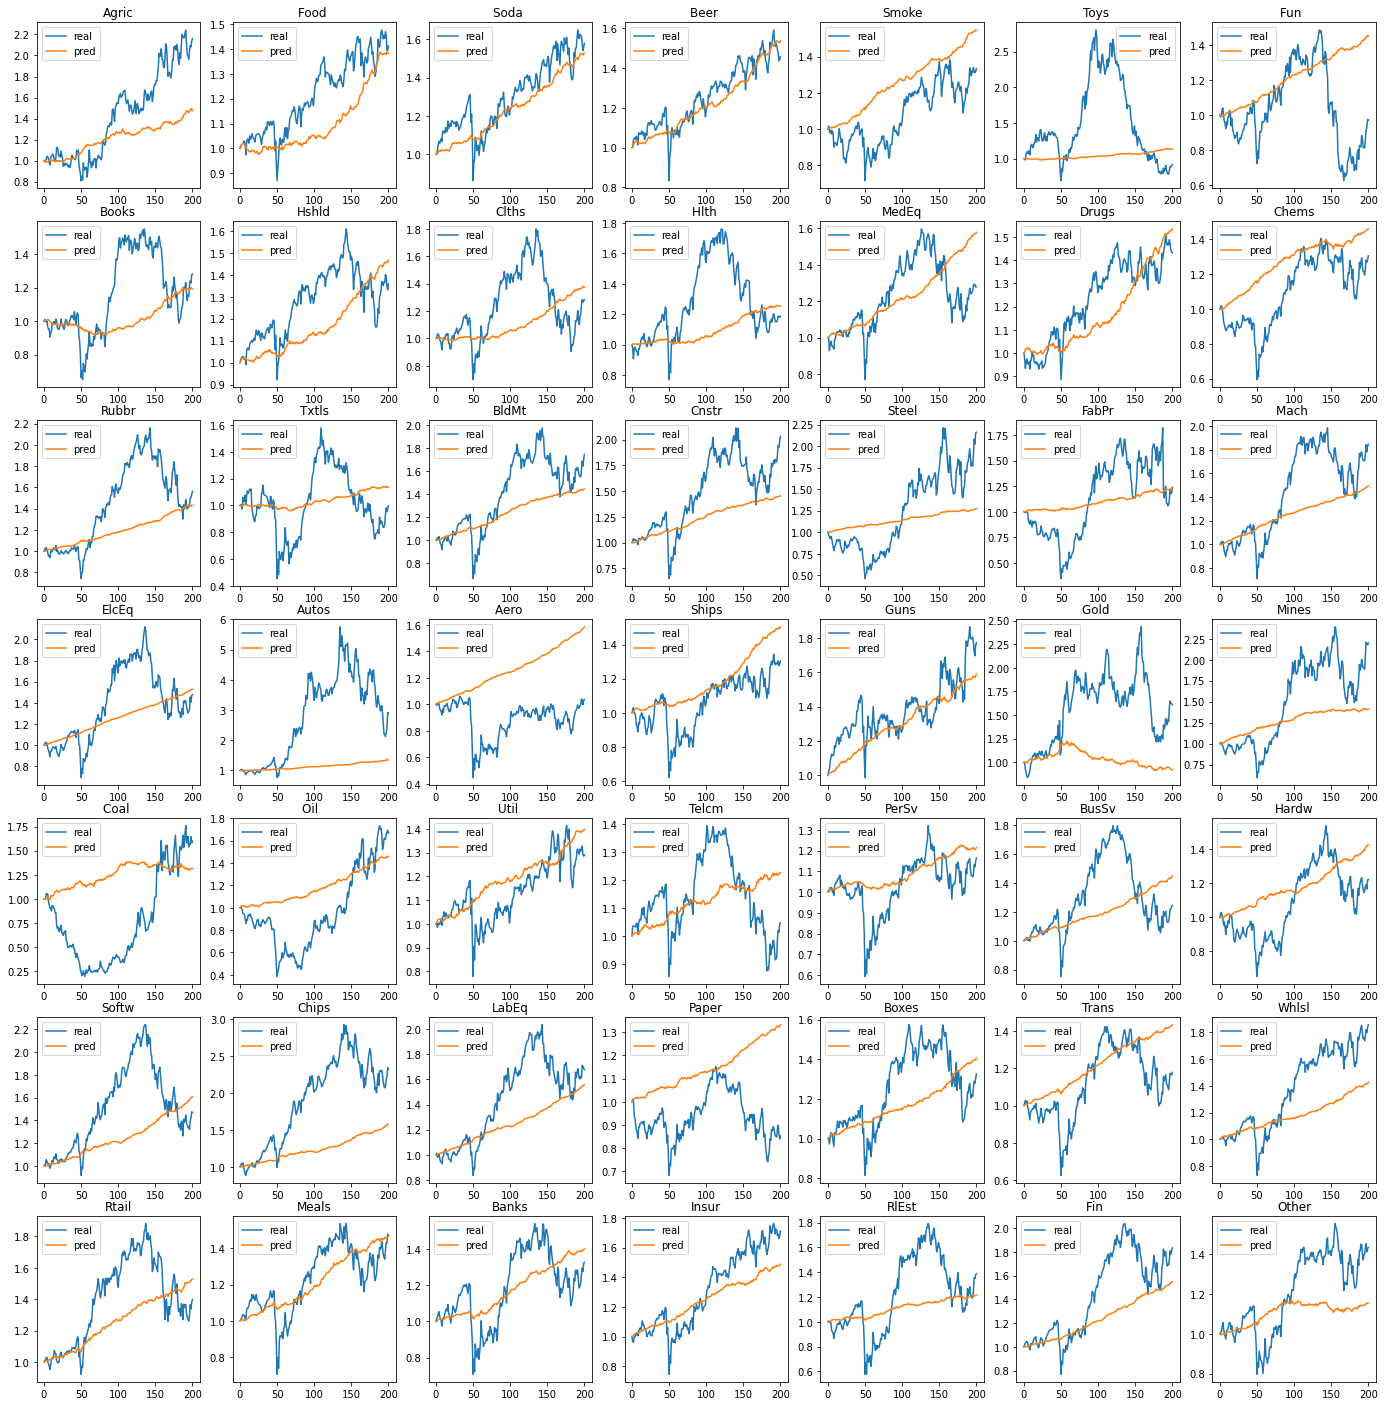

In [69]:
n_from = -200
fig, axs = plt.subplots(7, 7, figsize=(24, 16))
for i in range(N_COL):
    pred_price = calc_price(rtn_EFB[:, i][n_from:])
    real_price = calc_price(rtn_R[:, i][n_from:])

    ax = axs[i//7, i%7] # index the correct subplot
    ax.plot(real_price, label='real')
    ax.plot(pred_price, label='pred')
    ax.legend()
    ax.set_title(idx2sym[i])

plt.subplots_adjust(bottom=-0.3)
plt.show()